# Keras_CIFAR10_ResNet20

In [26]:
%matplotlib inline
import os
import PIL
import gzip
import tarfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython import display
from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

import warnings 
warnings.filterwarnings('ignore')
np.random.seed(42)

## 解压数据

In [27]:
data_dir = r"dataset"
cifar10_file = r"../input/cifar-10-python.tar.gz"

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
#以下shell指令是在Kaggle kernel中运行的，用以解压文件
# !cp ../input/cifar-10-python.tar.gz dataset/
# !tar xzvf dataset/cifar-10-python.tar.gz -C dataset/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


## 读取和切分数据集

In [28]:
cifar10_dir = r"cifar-10-batches-py"
filepath = os.path.join(data_dir, cifar10_dir)
files = os.listdir(filepath)

for fn in files:
    fp = os.path.join(filepath, fn)
    f = open(fp, 'rb')
    if "1" in fn:
        data_b = pickle.load(f, encoding="bytes")
        y_train = np_utils.to_categorical(data_b[b"labels"])
        X_train = np.array(data_b[b"data"])
    f.close()

for fn in files:
    fp = os.path.join(filepath, fn)
    f = open(fp, 'rb')
    if "data" in fn and "1" not in fn:
        data_b = pickle.load(f, encoding="bytes")
        imgs = np.array(data_b[b"data"])
        t_1hot = np_utils.to_categorical(data_b[b"labels"])
        y_train = np.vstack((y_train, t_1hot))
        X_train = np.vstack((X_train, imgs))
    elif "meta" in fn:
        meta = pickle.load(f, encoding="bytes")
        label_dict = [label.decode() for label in meta[b"label_names"]]
    elif "test" in fn:
        test_b = pickle.load(f, encoding="bytes")
        X_test = test_b[b"data"]
        labels = test_b[b"labels"]
        y_test = np_utils.to_categorical(labels)
    f.close()

"""规范化数据以及切分训练集、验证集和测试集"""
X_train = normalize(X_train, axis=0, norm="max")
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
X_test = normalize(X_test, axis=0, norm="max")
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000]
t_val   = y_train[:10000]

print("all files : \n", files)
print("\nall labels : \n", label_dict)
print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)

all files : 
 ['data_batch_2', 'readme.html', 'data_batch_5', 'batches.meta', 'test_batch', 'data_batch_4', 'data_batch_1', 'data_batch_3']

all labels : 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imgs   of trainset :  (40000, 32, 32, 3)
labels of trainset :  (40000, 10)
imgs   of   valset :  (10000, 32, 32, 3)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 32, 32, 3)
labels of  testset :  (10000, 10)


## 定义模型

In [29]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
   
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet20(input_shape=(32, 32, 3), depth=20, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # 开始模型定义
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # 实例化残差单元的堆栈
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # 第一层但不是第一个栈
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # 线性投影残差快捷键连接，以匹配更改的 dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # 在顶层加分类器。
    # v1 不在最后一个快捷连接 ReLU 后使用 BN
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # 实例化模型。
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = resnet20()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 32, 32, 16)   0           batch_normalization_58[0][0]     
__________________________________________________________________________________________________
conv2d_65 

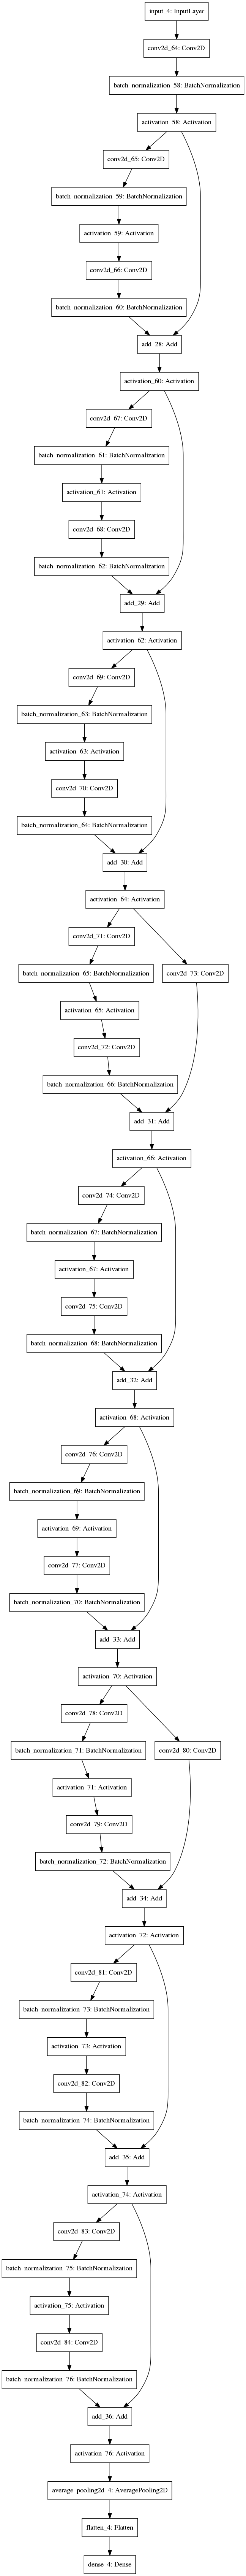

In [30]:
if not os.path.isdir(r"model_img"):
    os.mkdir(r"model_img")
plot_model(model, r"model_img/ResNet.png")
img = PIL.Image.open(r"model_img/ResNet.png")
display.display(img)

## 训练模型

In [31]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_CIFAR10_ResNet20_lr_v1" # 模型名称的公共前缀
factor_list = [""] # 此次调参的变量列表

model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_model"): 
    os.mkdir("saved_model")
modeldir = r"saved_model"

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history/Keras_CIFAR10_ResNet20_lr_v1.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 

epochs= 200
steps_per_epoch= 1250
for i in range(len(model_list)):
    model = resnet20()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    
    datagen = ImageDataGenerator(rotation_range=20, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               height_shift_range=0.2, 
                               width_shift_range=0.2, 
                               horizontal_flip=True)
    datagen.fit(x_train)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    
    lr = 0.001
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=32):
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            print("val acc improved from %6f to %6f"%(max_val_acc, val[1]))
            max_val_acc = val[1]
            ck_epoch = epoch
        # 调学习率: 当连续10周期性能没有提升
        if epoch and epoch%40 == 0 and lr > 1e-6:
            lr = lr*0.5
            ck_epoch = epoch
            model.compile(loss="categorical_crossentropy", 
                          optimizer=keras.optimizers.Adam(lr=lr),
                          metrics=["accuracy"])
            print("lr : ", lr)
        # 提前停止：当连续30周期性能没有提升
        if epoch-ck_epoch >40: 
            print("Early stop !")
            break  
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}

"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close() 


training model :  Keras_CIFAR10_ResNet20_lr_v1.h5
   0 epoch: train acc: 0.405650 loss: 1.800327      val acc: 0.496700 loss: 1.555954
val acc improved from 0.000000 to 0.496700
   1 epoch: train acc: 0.520925 loss: 1.489995      val acc: 0.548900 loss: 1.468308
val acc improved from 0.496700 to 0.548900
   2 epoch: train acc: 0.589100 loss: 1.316181      val acc: 0.603900 loss: 1.303892
val acc improved from 0.548900 to 0.603900
   3 epoch: train acc: 0.627750 loss: 1.212929      val acc: 0.631500 loss: 1.289372
val acc improved from 0.603900 to 0.631500
   4 epoch: train acc: 0.663450 loss: 1.123578      val acc: 0.651500 loss: 1.180423
val acc improved from 0.631500 to 0.651500
   5 epoch: train acc: 0.684275 loss: 1.069107      val acc: 0.610200 loss: 1.450704
   6 epoch: train acc: 0.701275 loss: 1.028623      val acc: 0.675500 loss: 1.153237
val acc improved from 0.651500 to 0.675500
   7 epoch: train acc: 0.711750 loss: 1.002293      val acc: 0.630500 loss: 1.495059
   8 epoch:

  86 epoch: train acc: 0.902575 loss: 0.429883      val acc: 0.880800 loss: 0.526578
  87 epoch: train acc: 0.907200 loss: 0.420254      val acc: 0.889100 loss: 0.499189
val acc improved from 0.881800 to 0.889100
  88 epoch: train acc: 0.904925 loss: 0.421797      val acc: 0.880700 loss: 0.543039
  89 epoch: train acc: 0.904125 loss: 0.421086      val acc: 0.883400 loss: 0.556344
  90 epoch: train acc: 0.907025 loss: 0.413081      val acc: 0.867800 loss: 0.619972
  91 epoch: train acc: 0.902775 loss: 0.418854      val acc: 0.891900 loss: 0.499592
val acc improved from 0.889100 to 0.891900
  92 epoch: train acc: 0.905700 loss: 0.414732      val acc: 0.877100 loss: 0.549072
  93 epoch: train acc: 0.905725 loss: 0.413319      val acc: 0.886800 loss: 0.518660
  94 epoch: train acc: 0.906950 loss: 0.405925      val acc: 0.896500 loss: 0.474460
val acc improved from 0.891900 to 0.896500
  95 epoch: train acc: 0.908550 loss: 0.401364      val acc: 0.876100 loss: 0.556030
  96 epoch: train acc

 177 epoch: train acc: 0.943500 loss: 0.264407      val acc: 0.901900 loss: 0.434766
 178 epoch: train acc: 0.944200 loss: 0.259660      val acc: 0.907700 loss: 0.423547
 179 epoch: train acc: 0.944925 loss: 0.262832      val acc: 0.906600 loss: 0.420314
 180 epoch: train acc: 0.945500 loss: 0.259449      val acc: 0.908700 loss: 0.419116
 181 epoch: train acc: 0.944650 loss: 0.259901      val acc: 0.908800 loss: 0.418322
 182 epoch: train acc: 0.947100 loss: 0.257637      val acc: 0.908500 loss: 0.418539
 183 epoch: train acc: 0.944900 loss: 0.256320      val acc: 0.911300 loss: 0.412724
val acc improved from 0.910200 to 0.911300
 184 epoch: train acc: 0.946600 loss: 0.259128      val acc: 0.911900 loss: 0.408770
val acc improved from 0.911300 to 0.911900
 185 epoch: train acc: 0.945675 loss: 0.258964      val acc: 0.904900 loss: 0.440258
 186 epoch: train acc: 0.946475 loss: 0.259576      val acc: 0.908200 loss: 0.415589
 187 epoch: train acc: 0.945350 loss: 0.258323      val acc: 0.9

## 可视化训练过程

In [32]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+modelname[21:-3])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label="val_"+modelname[21:-3])
            c += color_add
        ax[i].set_title('Train History')
        ax[i].set_ylabel(train[i])  
        ax[i].set_xlabel('Epoch')  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
    ax[0].set_ylim(0.3, 1.0)
    ax[1].set_ylim(0., 2)
    plt.suptitle("ResNet20_lr_v1")
    
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

saved img:  his_img/his_ResNet20_lr_v1.png


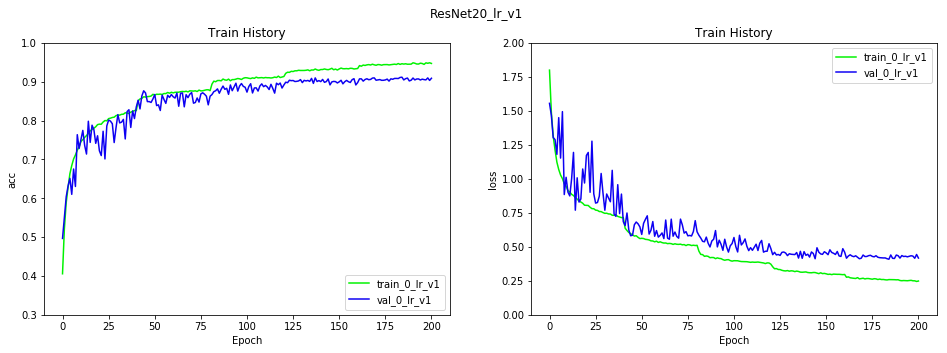

In [33]:
"""载入训练历史并可视化, 并且保存图片"""
if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img/his_ResNet20_lr_v1.png"

fo2 = open(hisfile, "rb")
saved_history1 = pickle.load(fo2)

show_train_history(saved_history1, his_img_file)

## 在测试集上测试

In [34]:
smodel = load_model(modelpath)

print("test model: ", os.path.basename(modelpath))
loss, acc = smodel.evaluate(X_test, y_test)
print("test ：acc: %.4f"%(acc))

test model:  Keras_CIFAR10_ResNet20_lr_v1.h5
10000/10000 [==============================] - 5s 546us/step
test ：acc: 0.9118
